# Patent Quality Prediction

Applied Project

Machine Learning: Applications in Economic Research

Supervisor: Dr. Laurentsyeva, Nadzeya

Submited by: Anton Vlasov (Anton.Vlasov@campus.lmu.de), Anna Popova (Anna.Popova@campus.lmu.de)

# Introduction

Patent “quality” is an ambiguous concept that acquired a variety of definitions and measures throughout the years (Squicciarini et al., 2013). Rapid technological development resulted in a drastic increase in the number of patents that are applied and authorized each year (Lin et al., 2018). However, the majority of existing quality measures are not designed for newly patented inventions since they are primarily built on time-dependent indicators (indicators that evolve throughout time). Thus, new patents a priori have fewer forward citations than older ones, which does not necessarily translate into worse quality. In this work, we aim at building a model to predict patents quality (number of forward citations) by using characteristics that a patent initially has. 

The main challenge in this work is to choose an outcome of the model – a measure of patent quality. Researchers in the field still argue the pros and cons of existing indexes.  Squicciarini et al. 2013 describe thirteen indicators of patent quality currently presented in the literature: patent scope; simple family size; grant lag (time elapsed between the filing date of the application and the date of the grant); backward citations; citations to non-patent literature; claims; forward citations; breakthrough inventions; generality index (Trajtenberg et al., 1997); originality index (Trajtenberg et al., 1997); radicalness index (Shane, 2001); patent renewal (OECD patent renewal indicator corresponds to the simple count of years during which a granted patent has been kept alive); patent quality index (Lanjouw and Schankerman, 2004). 

In our work, we concentrate on forward citations measure, the number of citations a patent receives, which reflects the technological importance for the development of subsequent technologies, and, thus, the field (Squicciarini et al., 2013). The number of forward citations is among the simplest yet the most popular measures of patent quality (Trajtenberg, 1990; Hall, et al., 2005; Harhoff et al., 2003). While a number forward citations is an inappropriate measure for the assessment of a new patent’s quality, it has several major advantages as an outcome variable: it represents the actual value of the patent for future inventions and it is relatively simple to acquire.   

We use the following characteristics of a patent to predict the number of forward citations: patent scope, number of distinct 4-digit subclasses of the International Patent Classification (IPC) the invention is allocated to; inventors count (number of inventors of a given patent); NPL citations (citations to non-patent literature); simple family size (number of patent offices at which a given invention has been protected); type (amended, granted, limited patent; patent application; search report); jurisdiction. Unlike citations, these characteristics are initially determined for each patent and do not change throughout time. However, these characteristics are crude measures of patents quality, as they mostly reflect the scope of investment in invention and aspirations for its future value and not its actual importance for the field’s development. Thus, using the basic patent’s characteristics to predict its quality is a promising research direction. 


In [1]:
%config InlineBackend.figure_formats = {'png', 'retina'}
import sys
import re
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn import ensemble

plt.rcParams["figure.dpi"] = 400

In [2]:
def count_values(name):
    return name.str.count(";;") + 1


def float_to_int(float_obj):
    return float_obj.fillna(0).astype("int64")


def cv(features, outcome, use, max_depth, n_folds, n_trees):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    if use == "ensemble":
        reg = ensemble.RandomForestRegressor(
            n_estimators=n_trees,
            min_samples_leaf=3,
            min_impurity_decrease=0.01,
            random_state=1,
        )
    else:
        reg = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=1)
    result = cross_validate(reg, features, outcome, scoring="neg_mean_squared_error")
    avg_score = np.mean(result["test_score"])
    return float(-avg_score)


def cv_mcc(features, outcome, alpha):
    cart = tree.DecisionTreeRegressor(ccp_alpha=alpha, random_state=1)
    result = cross_validate(cart, features, outcome, scoring="neg_mean_squared_error")
    avg_score = np.mean(result["test_score"])
    return float(-avg_score)

The empirical analysis draws on Lens.org open-source patent database. These data integrate multiple sources and enable a comprehensive analysis of patent filings worldwide. For example, the data cover granted patents of the European Patent Office dated from 1980 (What Is the Lens, 2021). The Lens reports standard fields within a patent document, including the inventor and the classification system attribution information (in our case, IPC). Besides, the resource tracks patent citations and summarizes them. 

We extract patent documents that correspond to the last version of this document within each simple patent family.

In [3]:
patents = pd.read_csv("lens-export.csv")
patents[["Inventors", "IPCR Classifications"]] = patents[
    ["Inventors", "IPCR Classifications"]
].apply(count_values)
patents[
    ["Publication Year", "Inventors", "IPCR Classifications", "Cited by Patent Count"]
] = patents[
    ["Publication Year", "Inventors", "IPCR Classifications", "Cited by Patent Count"]
].apply(
    float_to_int
)
patents.rename(
    columns={
        "Inventors": "Inventors Count",
        "IPCR Classifications": "IPCR Classifications Count",
    },
    inplace=True,
)
patents = patents[
    [
        "Publication Number",
        "Type",
        "Jurisdiction",
        "Publication Year",
        "Simple Family Size",
        "NPL Citation Count",
        "Inventors Count",
        "IPCR Classifications Count",
        "Cited by Patent Count",
    ]
]
patents["Type"] = patents["Type"].replace("unknown", np.nan)

So, the resulting dataset consists of nine variables ("Cited by Patent Count" is an outcome variable) and 3779 patent documents.

In [4]:
print(patents.shape)

(3779, 9)


In [5]:
patents.head()

,Publication Number,Type,Jurisdiction,Publication Year,Simple Family Size,NPL Citation Count,Inventors Count,IPCR Classifications Count,Cited by Patent Count
0,US 2011/0185700 A1,Patent Application,US,2011,1,0,1,1,8
1,US 8001762 B2,Granted Patent,US,2011,4,0,2,1,2
2,US 2020/0338494 A1,Patent Application,US,2020,2,0,1,2,0
3,US 5480107 A,Granted Patent,US,1996,1,0,1,1,21
4,WO 1995/027654 A1,Patent Application,WO,1995,4,1,1,1,3


The following six charts demonstrate the distribution of the key variables. The majority of patents are rather new with a relatively small number of citations, which corresponds to the idea that forward citations measure is a poor quality measure for new inventions

<AxesSubplot:xlabel='Cited by Patent Count', ylabel='Count'>

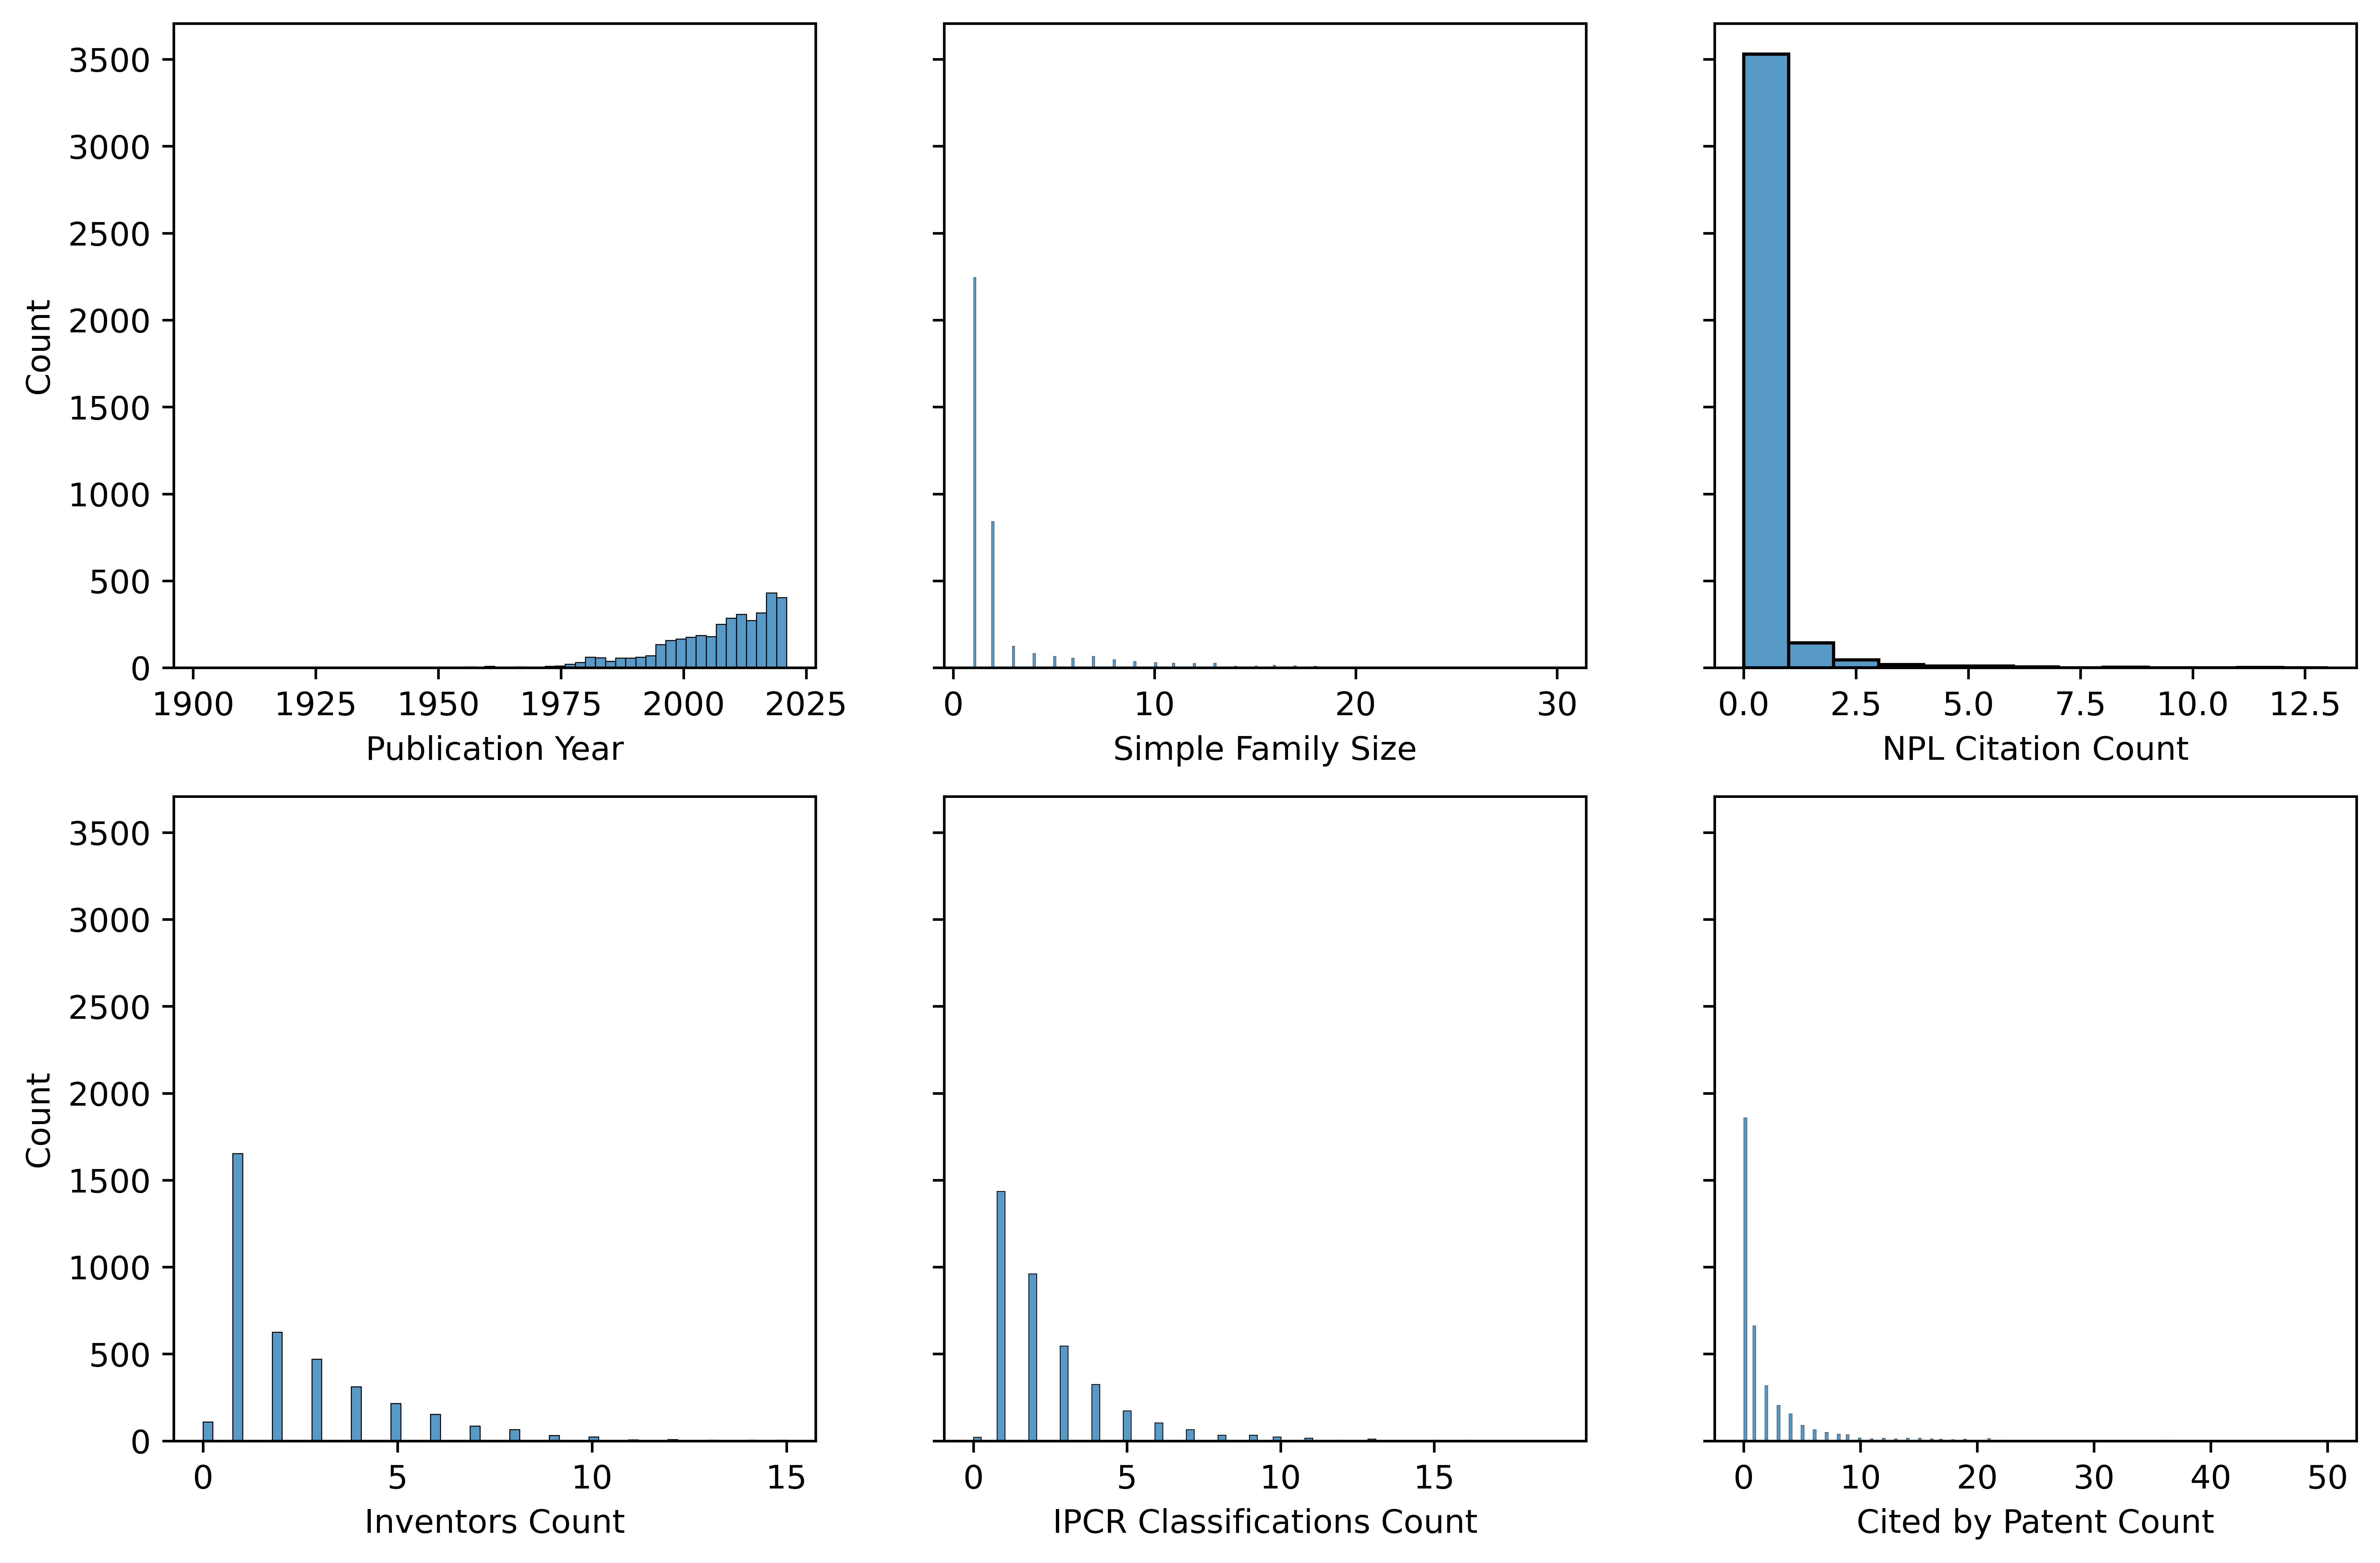

In [6]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True)
sns.histplot(
    x="Publication Year", data=patents[patents["Publication Year"] >= 1900], ax=ax1
)
sns.histplot(
    x="Simple Family Size", data=patents[patents["Simple Family Size"] <= 30], ax=ax2
)
sns.histplot(
    x="NPL Citation Count", data=patents[patents["NPL Citation Count"] <= 15], ax=ax3
)
sns.histplot(
    x="Inventors Count", data=patents[patents["Inventors Count"] <= 15], ax=ax4
)
sns.histplot(
    x="IPCR Classifications Count",
    data=patents[patents["IPCR Classifications Count"] <= 20],
    ax=ax5,
)
sns.histplot(
    x="Cited by Patent Count",
    data=patents[patents["Cited by Patent Count"] <= 50],
    ax=ax6,
)

We include all the characteristics of the patents discussed above as features: patent scope ("IPCR Classifications Count"); number of inventors ("Inventors Count"); number of non-patent literature resources cited ("NPL Citation Count"); simple family size; type; jurisdiction.   

In [7]:
features = patents[
    patents.columns.difference(
        ["Cited by Patent Count", "Publication Number", "Publication Year"]
    )
]
features = pd.get_dummies(features, columns=["Type", "Jurisdiction"])
cited = patents["Cited by Patent Count"]
features.columns

Index(['IPCR Classifications Count', 'Inventors Count', 'NPL Citation Count',
       'Simple Family Size', 'Type_Amended Patent', 'Type_Granted Patent',
       'Type_Limited Patent', 'Type_Patent Application', 'Type_Search report',
       'Jurisdiction_AR', 'Jurisdiction_AT', 'Jurisdiction_AU',
       'Jurisdiction_BE', 'Jurisdiction_BG', 'Jurisdiction_BR',
       'Jurisdiction_CA', 'Jurisdiction_CL', 'Jurisdiction_CN',
       'Jurisdiction_CR', 'Jurisdiction_DE', 'Jurisdiction_EA',
       'Jurisdiction_EP', 'Jurisdiction_ES', 'Jurisdiction_FR',
       'Jurisdiction_GB', 'Jurisdiction_GE', 'Jurisdiction_HU',
       'Jurisdiction_IN', 'Jurisdiction_JP', 'Jurisdiction_KR',
       'Jurisdiction_LT', 'Jurisdiction_LV', 'Jurisdiction_PH',
       'Jurisdiction_PL', 'Jurisdiction_RO', 'Jurisdiction_RU',
       'Jurisdiction_SU', 'Jurisdiction_TW', 'Jurisdiction_UA',
       'Jurisdiction_US', 'Jurisdiction_WO'],
      dtype='object')

In [8]:
features_train, features_test, cited_train, cited_test = train_test_split(
    features, cited, test_size=0.2, random_state=0
)

We run a CV procedure for a candidate model with a maximum depth of 19 to identify the optimal depth parameter for our model. 

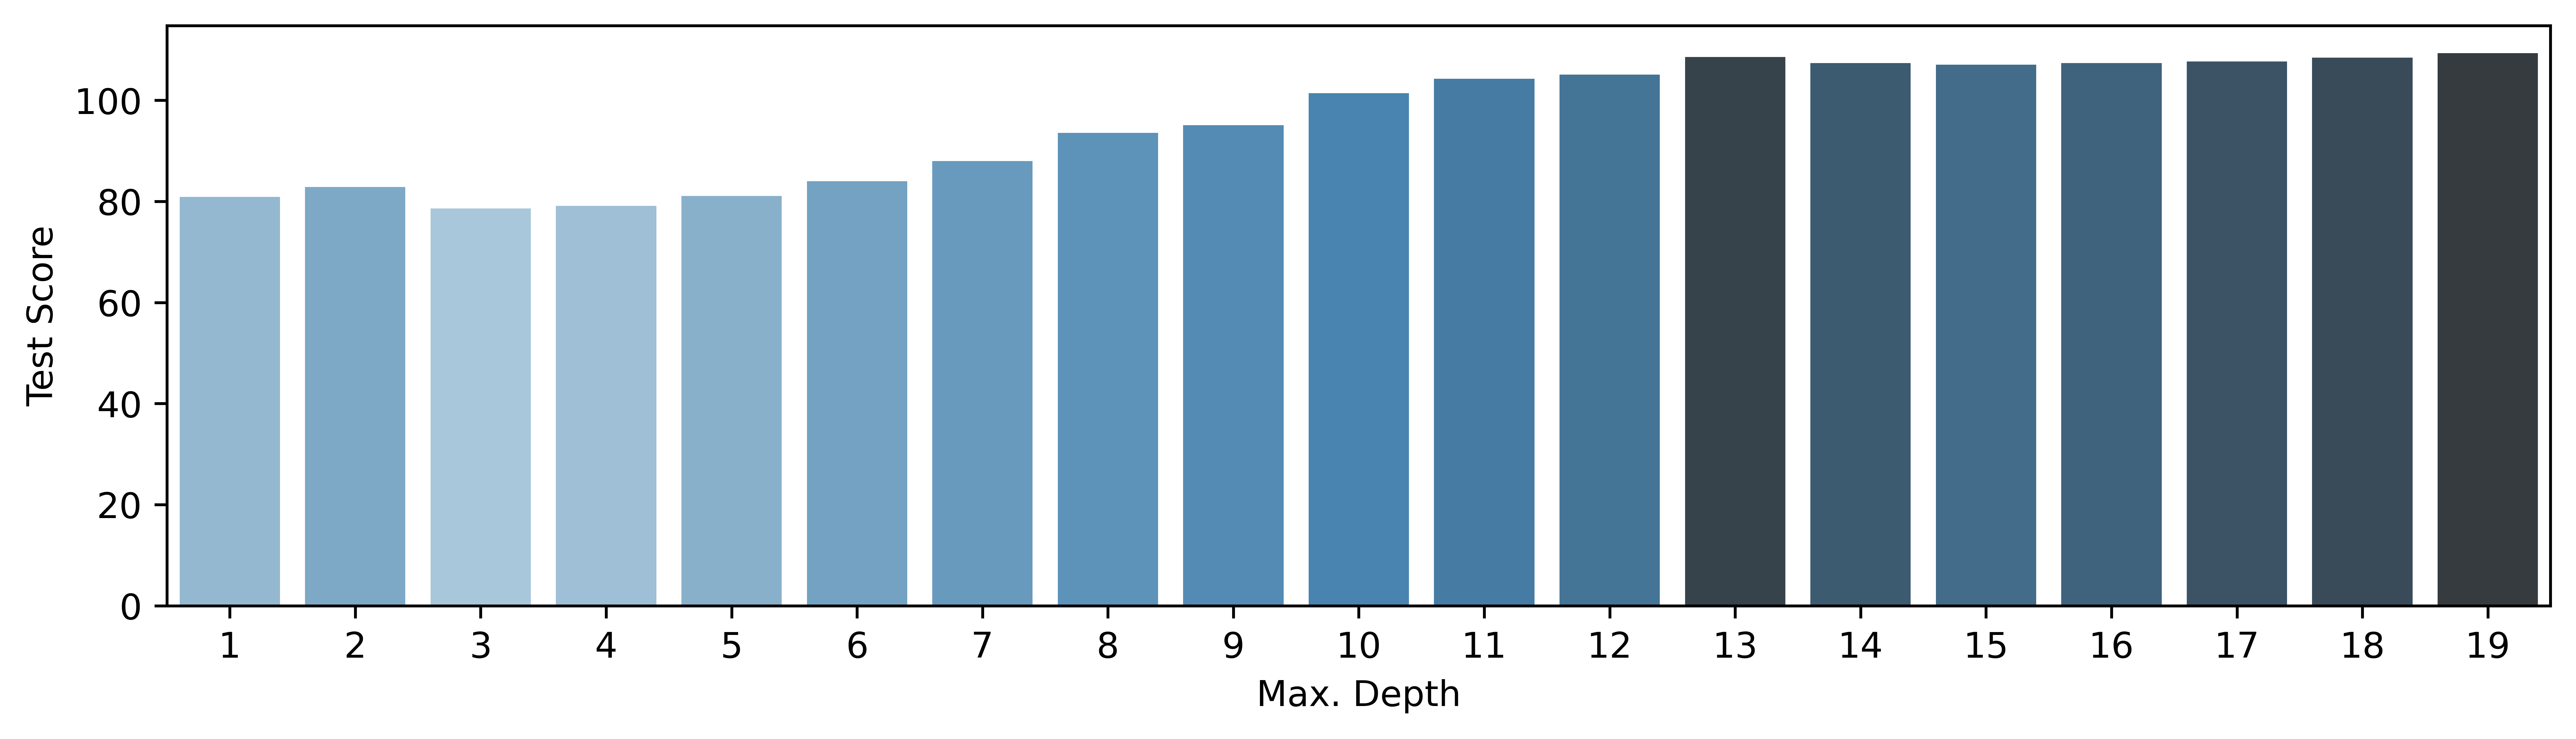

In [9]:
kfold_scores_cart = {}
for depth in range(1, 20):
    kfold_scores_cart[depth] = cv(features, cited, "tree", depth, 10, None)
plt.rcParams["figure.figsize"] = [12, 3]
kfold_scores_cart_df = pd.DataFrame.from_dict(
    kfold_scores_cart, orient="index", columns=["Test Score"]
)
cart_kfolds = sns.barplot(
    x=kfold_scores_cart_df.index,
    y=kfold_scores_cart_df["Test Score"],
    hue=kfold_scores_cart_df["Test Score"],
    dodge=False,
    palette="Blues_d",
)
cart_kfolds.set(xlabel="Max. Depth")
cart_kfolds.legend_.remove()
plt.show()

Then we refit our model using the maximum depth parameter identified from the CV procedure (3). The first results suggest that jurisdiction in the US, alongside the type of patent being either “granted” or “application”, jurisdiction in Germany, the number of non-patent sources cited and the number of inventors, are the most important parameters for predicting patent quality.

[Text(1860.0, 1057.0, 'Jurisdiction_US <= 0.5\nmse = 112.729\nsamples = 3023\nvalue = 3.58'),
 Text(930.0, 755.0, 'Type_Patent Application <= 0.5\nmse = 11.248\nsamples = 2671\nvalue = 1.471'),
 Text(465.0, 453.0, 'Jurisdiction_DE <= 0.5\nmse = 4.057\nsamples = 1444\nvalue = 0.954'),
 Text(232.5, 151.0, 'mse = 2.795\nsamples = 1411\nvalue = 0.882'),
 Text(697.5, 151.0, 'mse = 48.332\nsamples = 33\nvalue = 4.03'),
 Text(1395.0, 453.0, 'NPL Citation Count <= 0.5\nmse = 19.025\nsamples = 1227\nvalue = 2.08'),
 Text(1162.5, 151.0, 'mse = 12.456\nsamples = 1134\nvalue = 1.894'),
 Text(1627.5, 151.0, 'mse = 93.581\nsamples = 93\nvalue = 4.344'),
 Text(2790.0, 755.0, 'Type_Granted Patent <= 0.5\nmse = 593.033\nsamples = 352\nvalue = 19.58'),
 Text(2325.0, 453.0, 'Inventors Count <= 7.5\nmse = 559.917\nsamples = 133\nvalue = 13.023'),
 Text(2092.5, 151.0, 'mse = 555.346\nsamples = 132\nvalue = 12.765'),
 Text(2557.5, 151.0, 'mse = 0.0\nsamples = 1\nvalue = 47.0'),
 Text(3255.0, 453.0, 'Invento

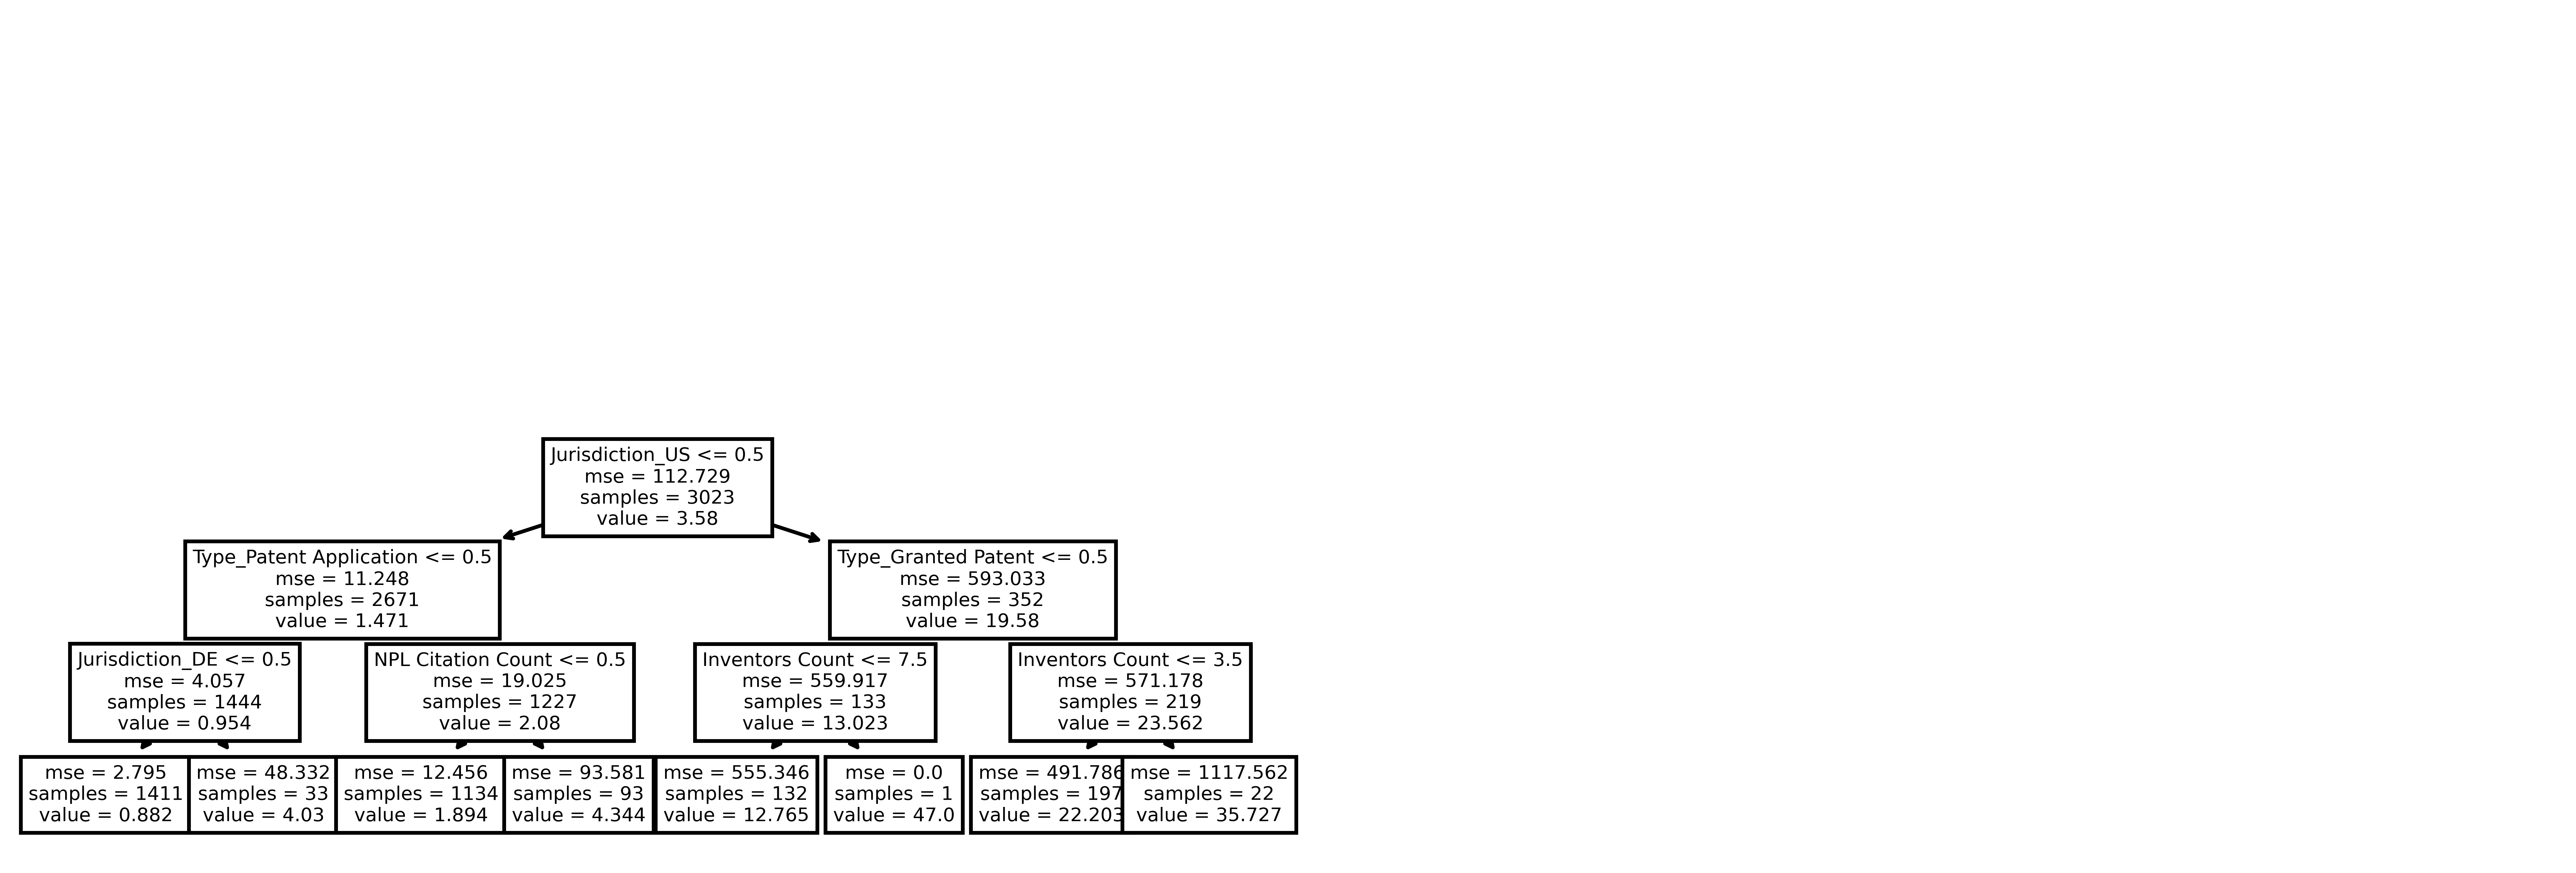

In [10]:
cart = tree.DecisionTreeRegressor(max_depth=3)
cart.fit(features_train, cited_train)
plt.rcParams["figure.figsize"] = [12, 4]
tree.plot_tree(cart, feature_names=list(features.columns))

In [11]:
cited_pred = cart.predict(features_test)
print("Tree depth: %.0f" % cart.get_depth())
print("Out-of-sample R^2, CART: %.3f" % r2_score(cited_test, cited_pred))
print("Out-of-sample MSE, CART: %.3f" % mean_squared_error(cited_test, cited_pred))

Tree depth: 3
Out-of-sample R^2, CART: 0.359
Out-of-sample MSE, CART: 76.268


Following the same procedure, after having patents with jurisdiction in the US removed, 
the jurisdiction in other countries (Japan, Romania, USSR, Austria, European Union) and the number of inventors are the most important features for predicting the patent’s quality.

We exclude the main feature related to the geographical factor (jurisdiction in the US) to distinguish between the impact of the US and the jurisdiction in general. Thus, as other jurisdiction appear to be important as well, jurisdictions of the patent play an important role in predicting its quality.       


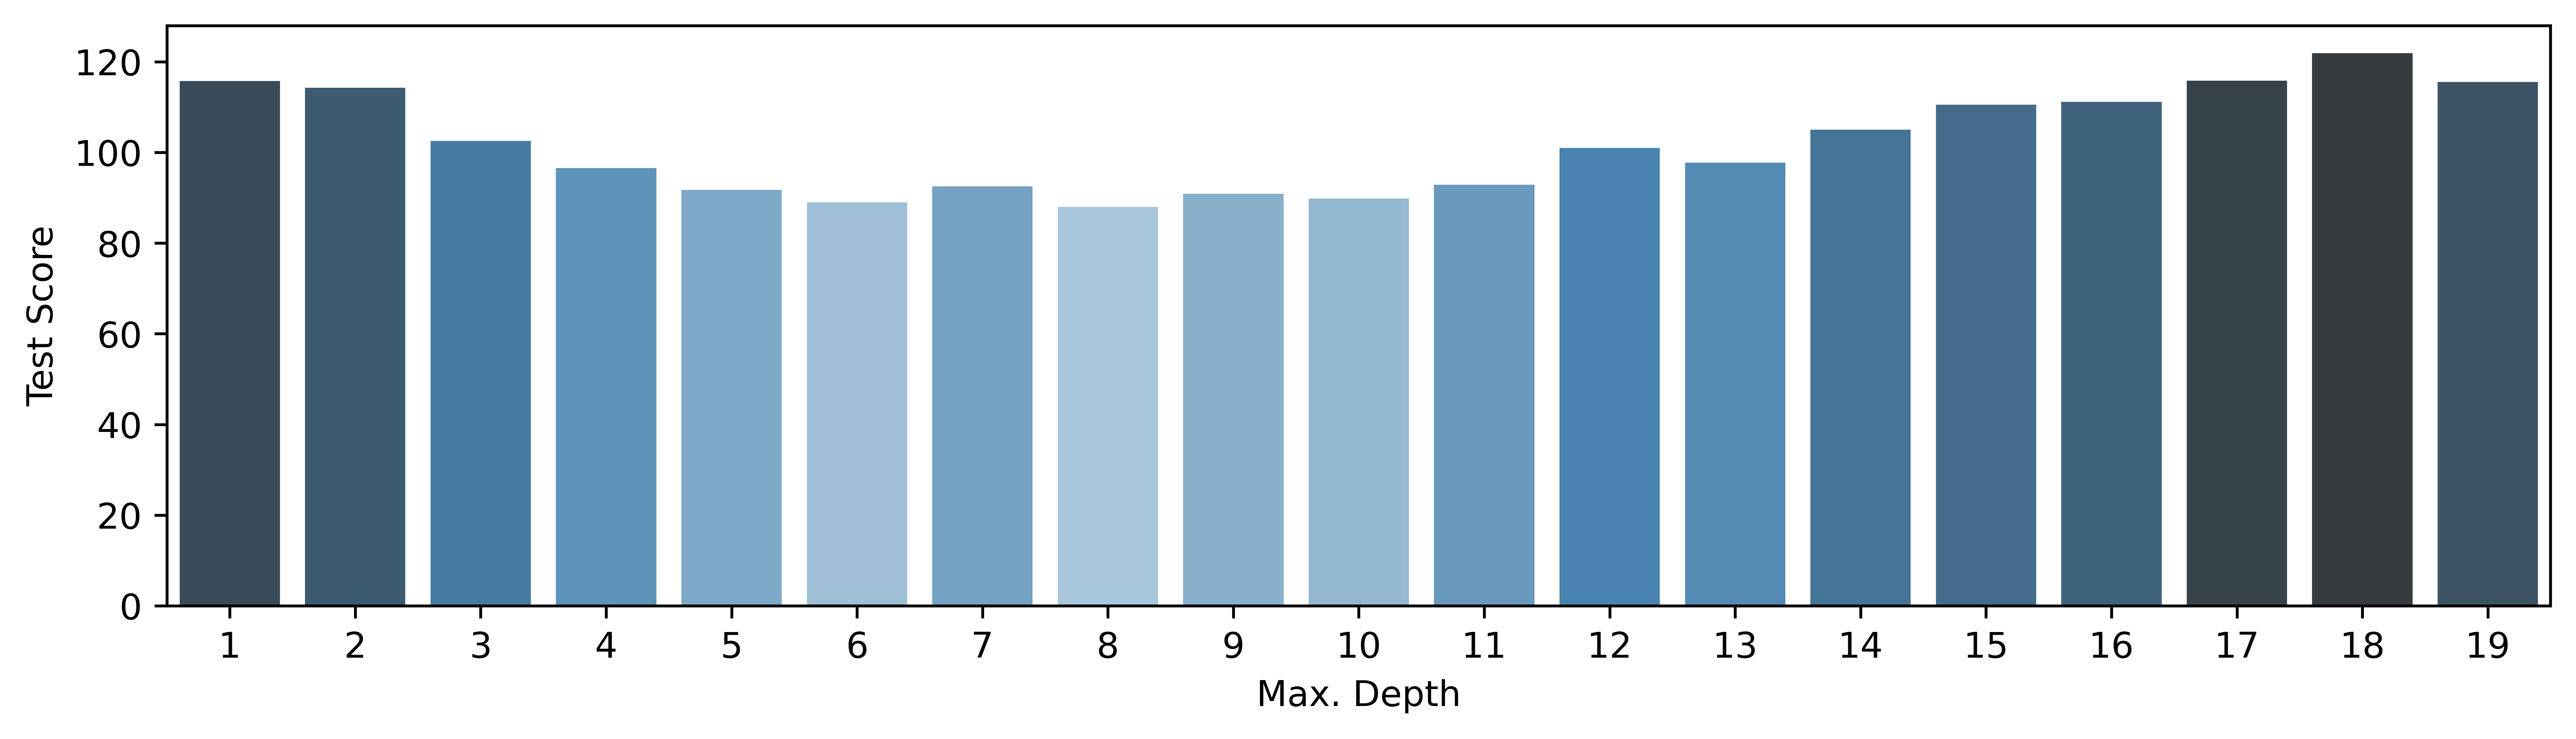

In [12]:
features_ = features[features.columns.difference(["Jurisdiction_US"])]
features__train, features__test = train_test_split(
    features_, test_size=0.2, random_state=0
)
kfold_scores_cart = {}
for depth in range(1, 20):
    kfold_scores_cart[depth] = cv(features_, cited, "tree", depth, 10, None)
plt.rcParams["figure.figsize"] = [12, 3]
kfold_scores_cart_df = pd.DataFrame.from_dict(
    kfold_scores_cart, orient="index", columns=["Test Score"]
)
cart_kfolds = sns.barplot(
    x=kfold_scores_cart_df.index,
    y=kfold_scores_cart_df["Test Score"],
    hue=kfold_scores_cart_df["Test Score"],
    dodge=False,
    palette="Blues_d",
)
cart_kfolds.set(xlabel="Max. Depth")
cart_kfolds.legend_.remove()
plt.show()

[Text(2247.5, 1087.2, 'Jurisdiction_JP <= 0.5\nmse = 112.729\nsamples = 3023\nvalue = 3.58'),
 Text(1240.0, 845.6, 'Jurisdiction_SU <= 0.5\nmse = 144.931\nsamples = 2287\nvalue = 4.478'),
 Text(620.0, 604.0, 'Jurisdiction_AT <= 0.5\nmse = 62.583\nsamples = 1864\nvalue = 2.65'),
 Text(310.0, 362.4, 'Jurisdiction_EP <= 0.5\nmse = 115.276\nsamples = 931\nvalue = 3.913'),
 Text(155.0, 120.79999999999995, 'mse = 191.944\nsamples = 526\nvalue = 5.093'),
 Text(465.0, 120.79999999999995, 'mse = 11.544\nsamples = 405\nvalue = 2.38'),
 Text(930.0, 362.4, 'Jurisdiction_RO <= 1.5\nmse = 6.821\nsamples = 933\nvalue = 1.389'),
 Text(775.0, 120.79999999999995, 'mse = 6.674\nsamples = 770\nvalue = 1.175'),
 Text(1085.0, 120.79999999999995, 'mse = 6.277\nsamples = 163\nvalue = 2.399'),
 Text(1860.0, 604.0, 'Jurisdiction_RO <= 1.5\nmse = 428.135\nsamples = 423\nvalue = 12.537'),
 Text(1550.0, 362.4, 'Jurisdiction_CN <= 0.5\nmse = 560.668\nsamples = 155\nvalue = 20.284'),
 Text(1395.0, 120.79999999999995

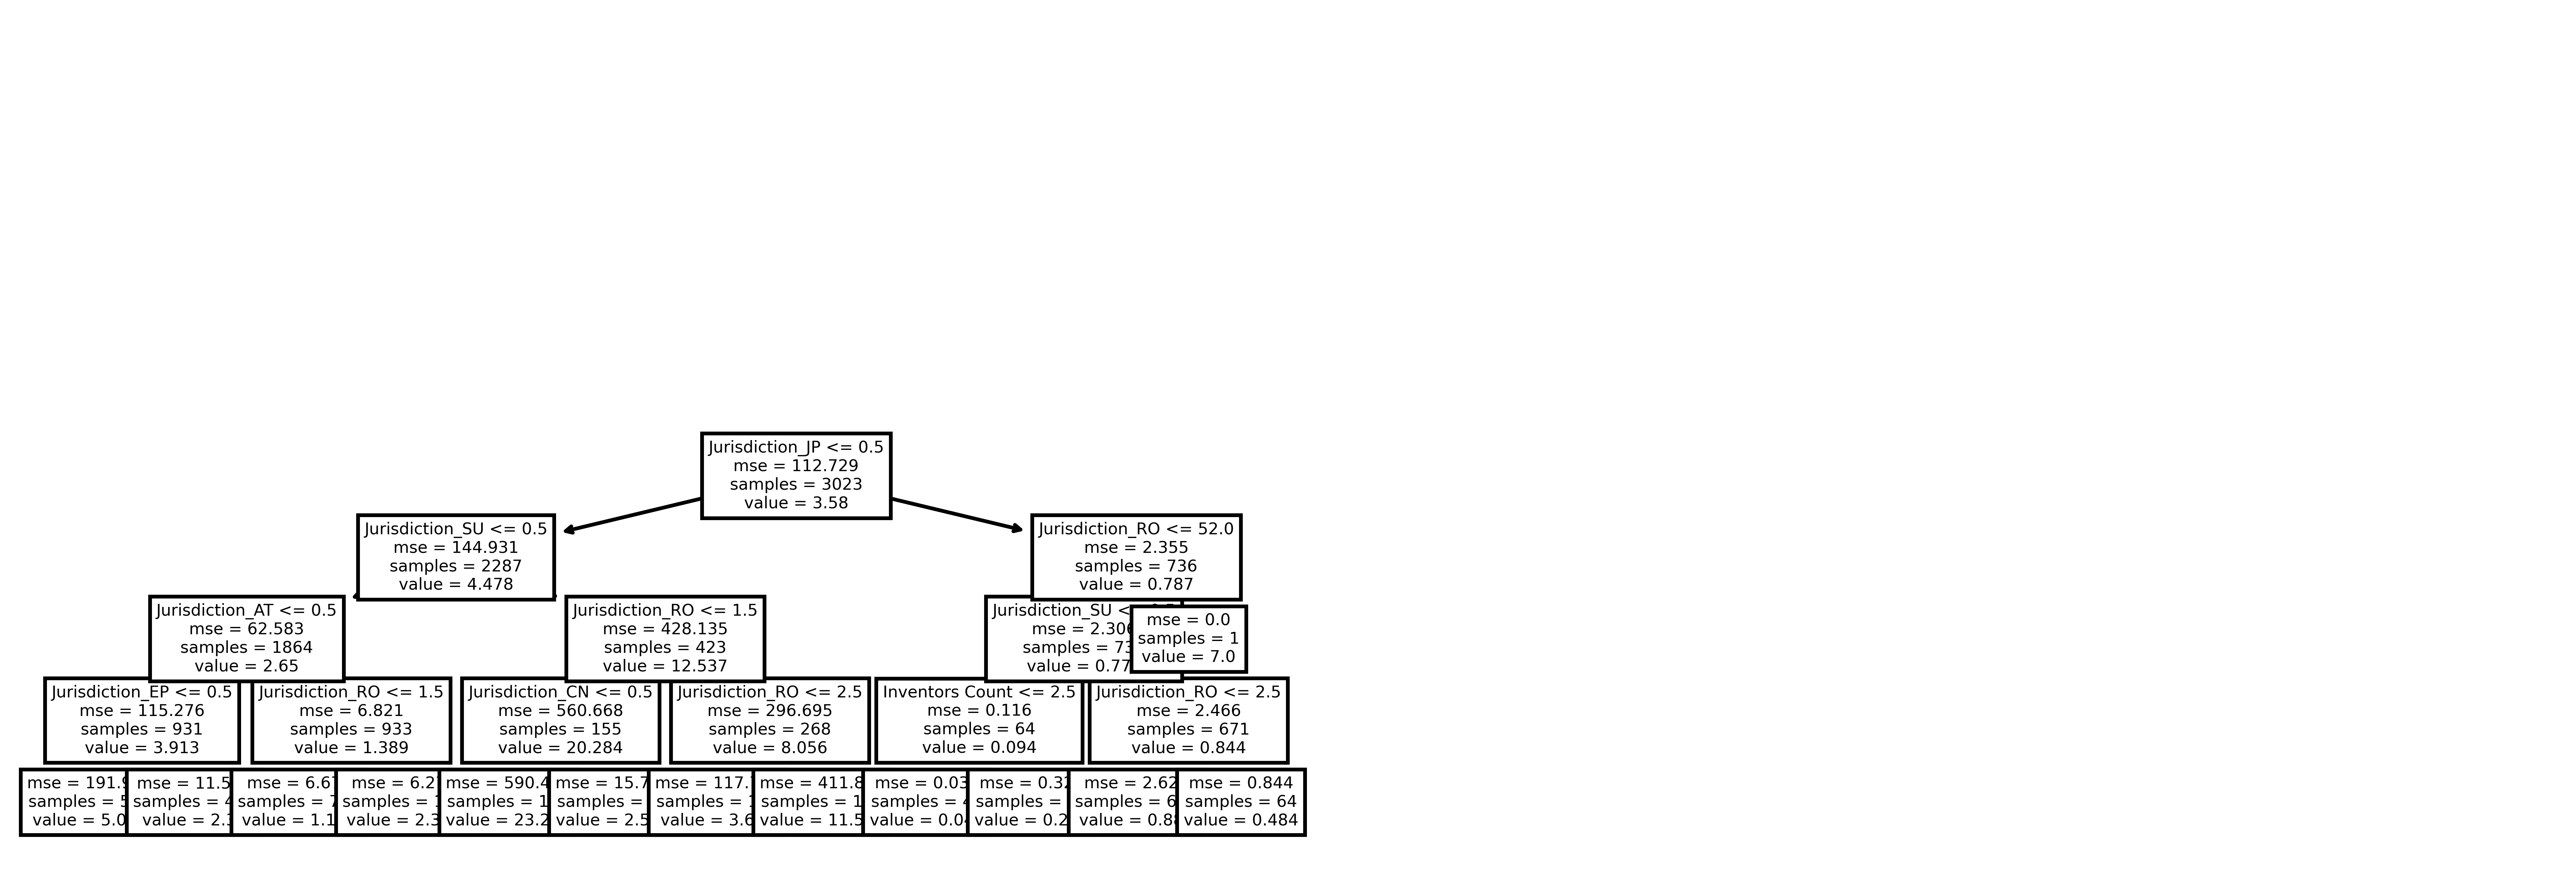

In [13]:
cart = tree.DecisionTreeRegressor(max_depth=4)
cart.fit(features__train, cited_train)
plt.rcParams["figure.figsize"] = [12, 4]
tree.plot_tree(cart, feature_names=list(features.columns))

Next we use the cost complexity parameter, alpha, to identify the size of the tree.  

<AxesSubplot:xlabel='Effective Alpha', ylabel='Total Impurities'>

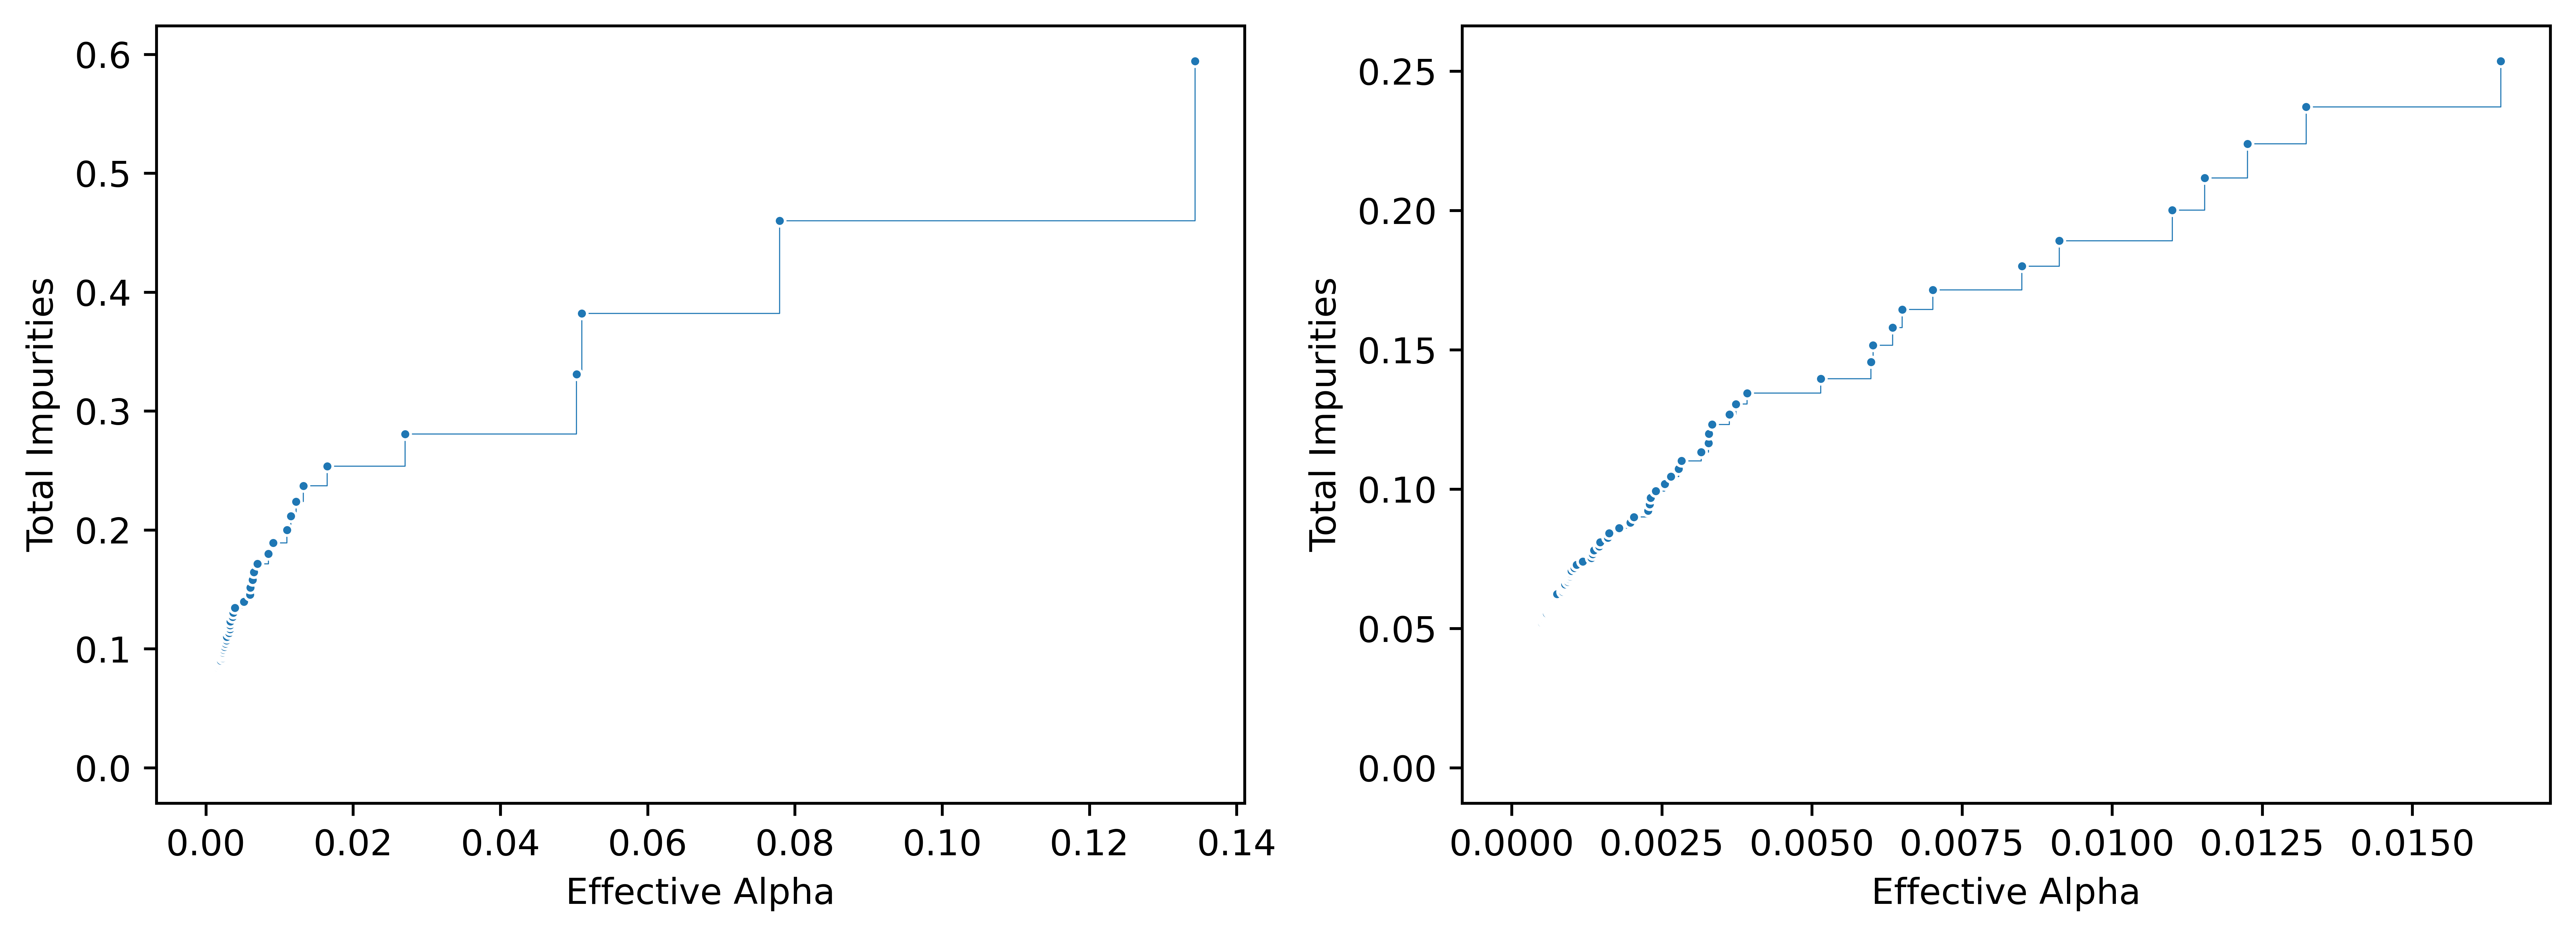

In [14]:
cart = tree.DecisionTreeRegressor(random_state=1)
path = cart.cost_complexity_pruning_path(features_train, features_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
alphas_impurities = pd.DataFrame(
    {"Effective Alpha": ccp_alphas[:-1], "Total Impurities": impurities[:-1]}
)
plt.rcParams["figure.figsize"] = [12, 4]
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.lineplot(
    x="Effective Alpha",
    y="Total Impurities",
    data=alphas_impurities,
    marker="o",
    drawstyle="steps-post",
    linewidth=0.3,
    markersize=3,
    ax=ax1,
)
sns.lineplot(
    x="Effective Alpha",
    y="Total Impurities",
    data=alphas_impurities[alphas_impurities["Effective Alpha"] <= 0.02],
    marker="o",
    drawstyle="steps-post",
    linewidth=0.3,
    markersize=3,
    ax=ax2,
)

When alpha equals 0.02, test score is minimized. This alpha corresponds to the tree depth of 15. 

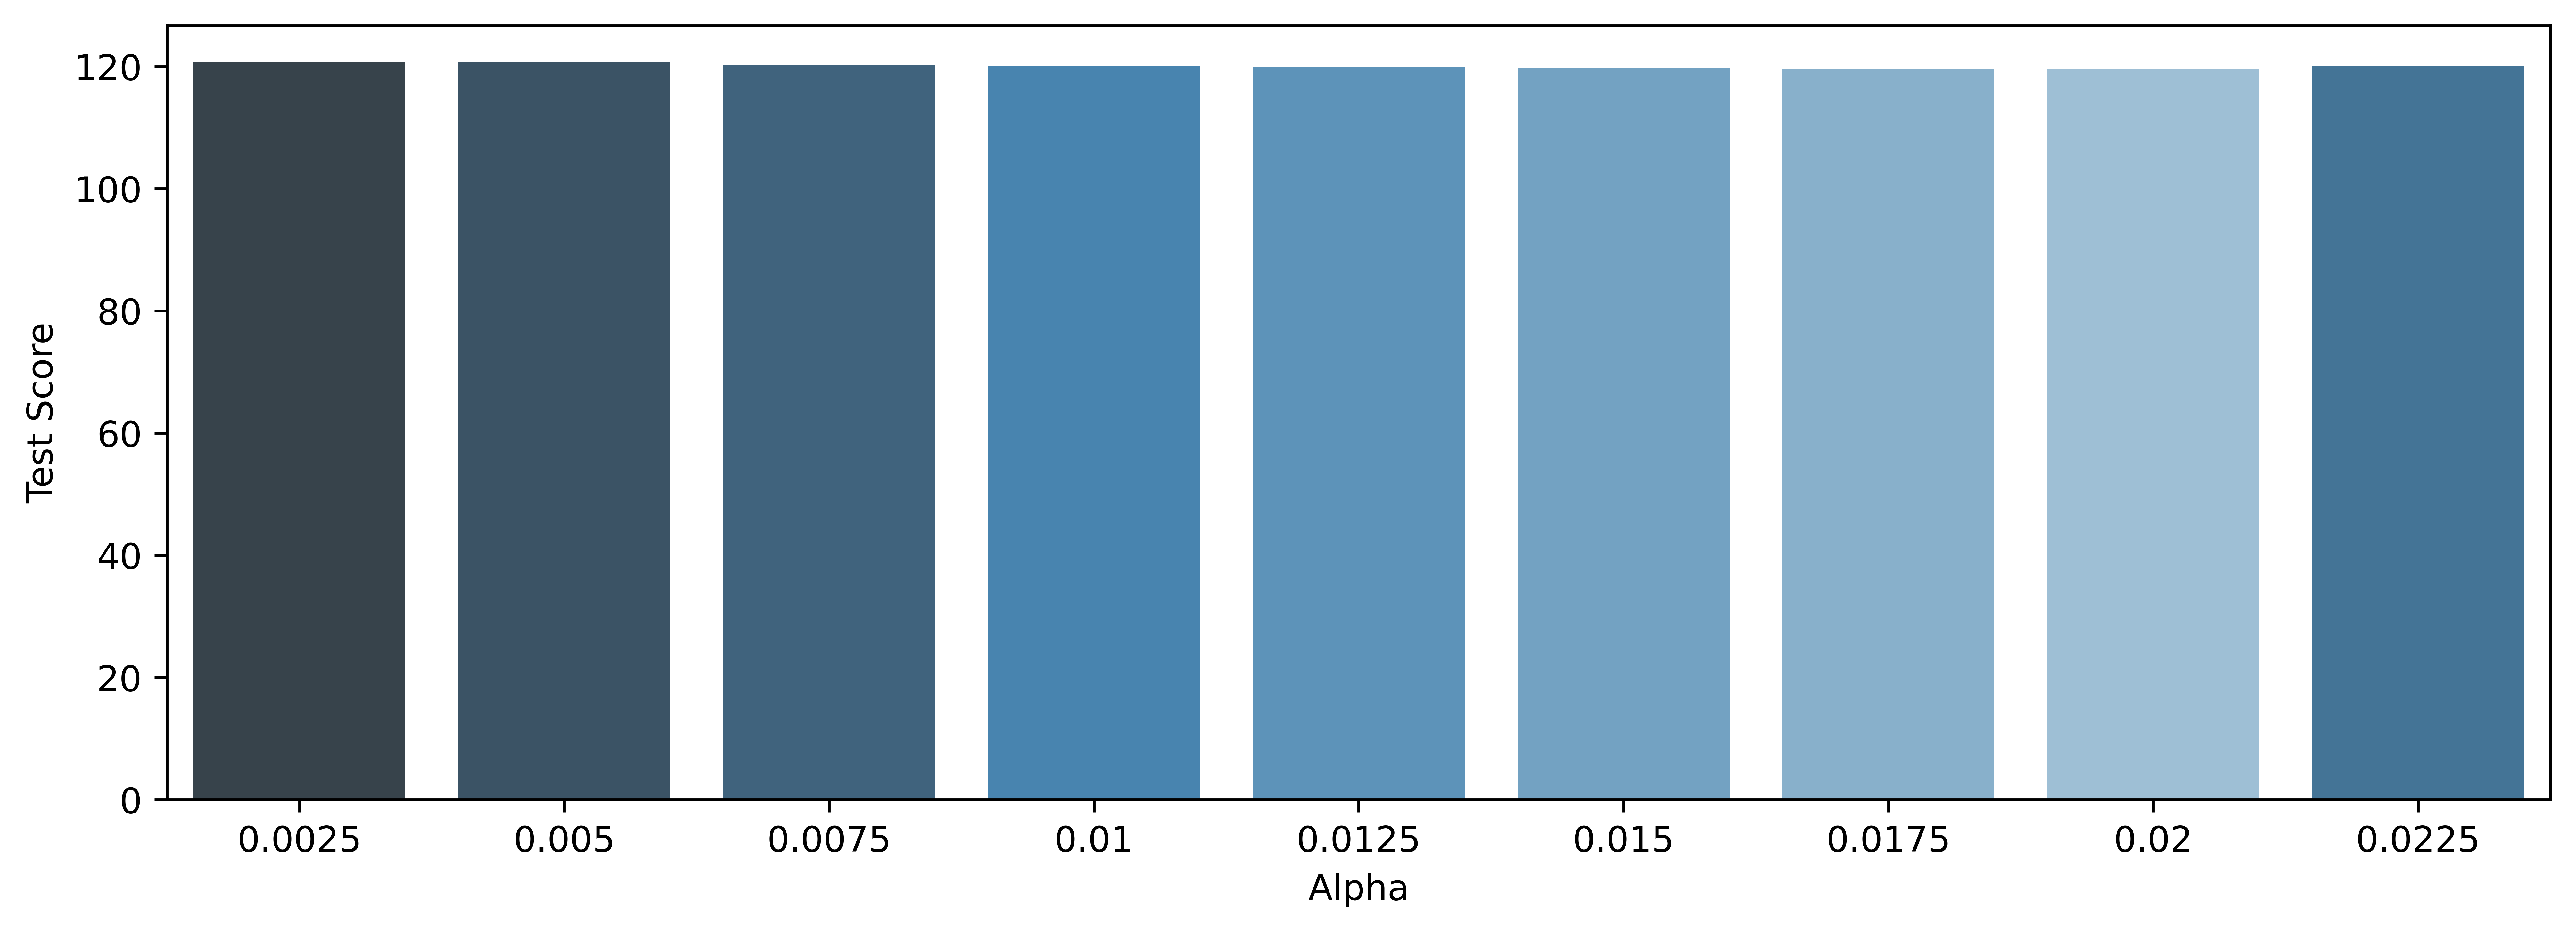

In [15]:
alpha_trials = {}
for alpha in [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225]:
    alpha_trials[alpha] = cv_mcc(features_train, cited_train, alpha)
plt.rcParams["figure.figsize"] = [12, 4]
alpha_trials_df = pd.DataFrame.from_dict(
    alpha_trials, orient="index", columns=["Test Score"]
)
cart_alphas = sns.barplot(
    x=alpha_trials_df.index,
    y=alpha_trials_df["Test Score"],
    hue=alpha_trials_df["Test Score"],
    dodge=False,
    palette="Blues_d",
)
cart_alphas.set(xlabel="Alpha")
cart_alphas.legend_.remove()
plt.show()

In [16]:
cart = tree.DecisionTreeRegressor(ccp_alpha=0.02, random_state=1)
cart = cart.fit(features_train, cited_train)
cited_pred = cart.predict(features_test)
print("Tree Depth: %.0f" % cart.get_depth())
print("Out-of-sample R^2: %.3f" % r2_score(cited_test, cited_pred))
print("Out-of-sample MSE: %.3f" % mean_squared_error(cited_test, cited_pred))

Tree Depth: 15
Out-of-sample R^2: -0.094
Out-of-sample MSE: 130.045


The next step is bagging the CART trees to introduce randomization into the procedure. 

In [17]:
kfold_scores_rf = {}
for n_trees in range(1, 200, 10):
    kfold_scores_rf[n_trees] = cv(
        features_train, cited_train, "ensemble", None, 3, n_trees
    )

<AxesSubplot:xlabel='No. Trees', ylabel='Test Score'>

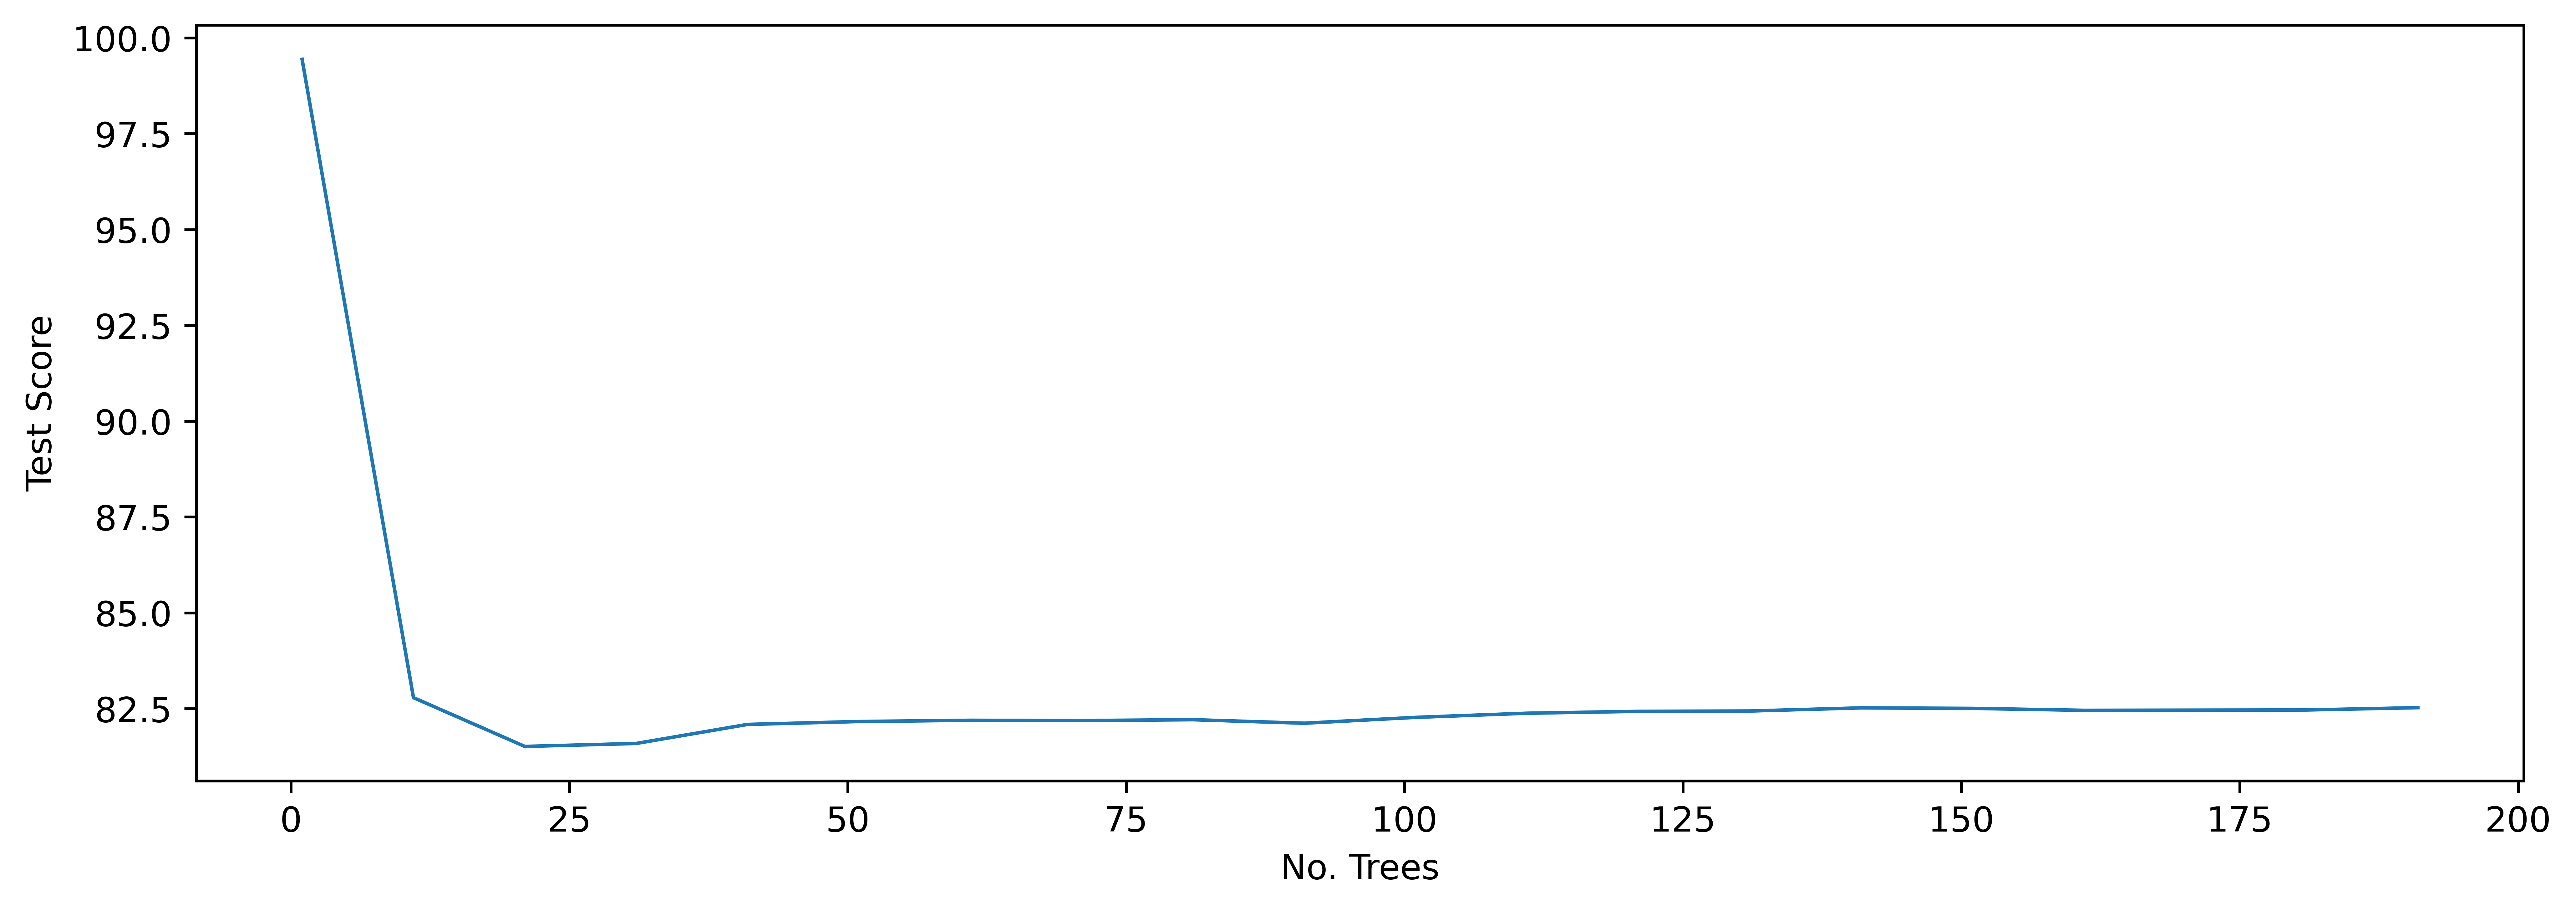

In [18]:
plt.rcParams["figure.figsize"] = [12, 4]
pd.DataFrame(kfold_scores_rf.items(), columns=["No. Trees", "Test Score"])
kfold_scores_rf_df = pd.DataFrame(
    kfold_scores_rf.items(), columns=["No. Trees", "Test Score"]
)
sns.lineplot(x="No. Trees", y="Test Score", data=kfold_scores_rf_df, linewidth=1)

Based on the previous step that builds the range of optimal number of trees, we identify the optimal parameters  for the regression.  

In [ ]:
params = {
    "n_estimators": np.arange(20, 30),
    "max_features": ["auto", "sqrt"],
    "max_depth": np.arange(1, 13),
    "min_samples_split": [5, 10],
}
rf_tuned = GridSearchCV(
    estimator=ensemble.RandomForestRegressor(), param_grid=params, cv=10, verbose=0
)
rf_tuned.fit(features_train, cited_train)
cited_pred = rf_tuned.predict(features_test)
rf_tuned.best_params_

In [ ]:
print("Out-of-sample R^2: %.3f" % r2_score(cited_test, cited_pred))
print("Out-of-sample MSE: %.3f" % mean_squared_error(cited_test, cited_pred))

The outcomes of the random forests regression correspond to the previous results. Thus, jurisdiction in the US is an important predictor of the patent's quality, so are types of patent "application" and "granted", number of NPL citations and number of inventors. 

In [ ]:
feature_names = list(features.columns.values)
ordered_features_df = pd.DataFrame(
    {
        "Feature": list(features.columns.values),
        "Importance": rf_tuned.best_estimator_.feature_importances_,
    }
).sort_values(by=["Importance"], ascending=False)
plt.rcParams["figure.figsize"] = [12, 8]
ordered_features = sns.barplot(
    x="Importance",
    y="Feature",
    data=ordered_features_df,
    hue=ordered_features_df["Importance"],
    dodge=False,
    palette="Blues_d",
)
ordered_features.legend_.remove()
plt.show()

# Discussion 

In our project, we aim at predicting a patent’s quality by the set of its initial characteristics by using the CART Algorithm (Breiman et al., 1984). The basic results suggest that patents with jurisdiction in the US are more likely to be cited, thus, have higher quality. Besides, other characteristics, such as type of patent, number of inventors and NPL cited are important features. Furthermore, other jurisdictions also determine patents with more forward citations. Outcomes from the first step correspond to the the outcome sof the random forests regreassion, which supports the validity of the results. 

It is noteworthy, that USSR is among important jurisdictions in terms of patent's quality prediction. Since the country no longer exists, it is impossible to use this as a parameter to predict the quality of new patents. However, we decided to leave the patents with jurisdiction in the USSR as their exclusion could significantly bias the results. 


Nevertheless, the outcome variable is a major challenge in this project. Ideally, we would have a quality index that takes into account the specifics of the field, as well as other factors contributing to the patent quality. Forwards citations is a rather simple method with several significant drawbacks. First, the patent quality is more involved than simple citation count – a number of other factors represent the patent’s quality. Second, the measure itself does not take into account the type of citations a patent receives: some citations are more important than others in terms of predicting quality of invention but in our case citations do not enter the measure with different weights. Third, changes in European Patent Office guidelines through the years affect the classification of citations’ types which can introduce a measurement error for patents published earlier.    

A composite index of patent quality might be the closest to the “ideal” measure. The index builds on Lanjouw and Shankerman (2004) and includes forward citations, patent family size, the number of claims, generality index, backward citations, and grant lag. This index takes into account several sides of the quality measure but does not account for the different weights of these components in the final index. Furthermore, other, more sophisticated methods for assessing patents quality built on existing measures are introduced in the literature (e.g., Lin et al., 2018), which could be used in the further development of this project. 

# References 

Breiman L., Friedman J., Stone C. J., and Olshen R.A. 1984. “Classification and Regression Trees”. Chapman and Hall/CRC. 

Lanjouw, J. and Schankerman M. 2004. “Patent Quality and Research Productivity: Measuring Innovation with Multiple Indicators”, The Economic Journal, 114(495): 441-465.

Lin, H., Hao W., Dongfang D., Han W., Biao C., and Enhong C. 2018.  “Patent Quality Valuation with Deep Learning Models." Edited by Jian Pei, Yannis Manolopoulos, Shazia Sadiq, and Jianxin Li. In Database Systems for Advanced Applications, 474-490. Lecture Notes in Computer Science. Cham: Springer International Publishing. 

Shane, S. 2001. “Technological Opportunities and New Firm Creation”, Management Science, 47 (2):205–220.

Squicciarini, M., Dernis H. and Criscuolo C. 2013. "Measuring Patent Quality: Indicators of Technological and Economic Value", OECD Science, Technology and Industry Working Papers, No. 2013/03, OECD Publishing, Paris.

Trajtenberg, M., Jaffe, A., and Henderson R. 1997. “University versus Corporate Patents: A Window on the Basicness of Inventions”, Economics of Innovation and New Technology, 5(1): 19-50.

“What Is the Lens.” About The Lens. Accessed March 13, 2021. https://about.lens.org.